<a href="https://colab.research.google.com/github/Tash518/omr_project/blob/main/ocrapp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### main

In [76]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras import datasets, Layer, Model
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
import cv2

In [2]:
print("TensorFlow version:", tf.__version__)
print("keras version", keras.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.19.0
keras version 3.10.0
Num GPUs Available: 0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
ds,  ds_info = tfds.load('emnist/byclass', split=['train','test'], as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/byclass/incomplete.3RDG40_3.1.0/emnist-train.tfrecord*...:   0%|   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/byclass/incomplete.3RDG40_3.1.0/emnist-test.tfrecord*...:   0%|    …

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/byclass/3.1.0. Subsequent calls will reuse this data.


In [5]:
ds_train, ds_test = ds

In [64]:
NUM_CLASS = ds_info.features['label'].num_classes

#preprocessing
def preprocess(image,label):
  image = tf.cast(image,tf.float32)/255        #normaize
  if tf.rank(image)<3:
    image = tf.expand_dims(image,-1)          #add color channel if not there already
  image = tf.image.transpose(image)      # swap x and y axes
#  image = tf.image.flip_left_right(image)  # mirror horizontally

  image.set_shape([28,28,1])           #explicityy set shape if needed
  return (image, label)

NameError: name 'ds_info' is not defined

preprocess test

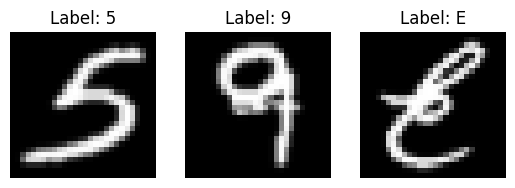

In [8]:
test_images = ds_train.take(3)
preprocessed_test_images = test_images.map(preprocess)
for i, (image, label) in enumerate(preprocessed_test_images):
    plt.subplot(1, 3, i + 1)
    plt.imshow(image.numpy().squeeze(), cmap="gray")
    plt.title(f"Label: {class_names[label]}")
    plt.axis("off")

plt.show()

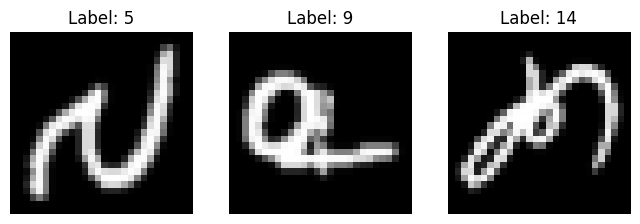

In [9]:
samples = list(ds_train.take(3))

plt.figure(figsize=(8, 3))
for i, (image, label) in enumerate(samples):
    plt.subplot(1, 3, i + 1)
    plt.imshow(image.numpy().squeeze(), cmap="gray")
    plt.title(f"Label: {label.numpy()}")
    plt.axis("off")

plt.show()

will try to make list for rcnn


In [6]:
preprocessed_ds_train = ds_train.map(preprocess).shuffle(10000)


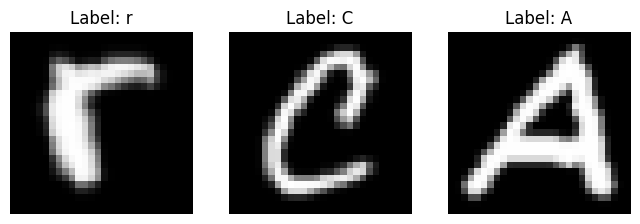

In [11]:
samples = list(preprocessed_ds_train.take(3))

plt.figure(figsize=(8, 3))
for i, (image, label) in enumerate(samples):
    plt.subplot(1, 3, i + 1)
    plt.imshow(image.numpy().squeeze(), cmap="gray")
    plt.title(f"Label: {class_names[label]}")
    plt.axis("off")

plt.show()

In [66]:
class_names = ['0','1','2','3','4','5','6','7','8','9',
               'A','B','C','D','E','F','G','H','I','J',
               'K','L','M','N','O','P','Q','R','S','T',
               'U','V','W','X','Y','Z',
               'a','b','c','d','e','f','g','h','i','j',
               'k','l','m','n','o','p','q','r','s','t',
               'u','v','w','x','y','z']

In [67]:
NUM_CLASSES = len(class_names)

In [68]:
NUM_CLASSES

62

In [8]:
emnist_cache = {i: [] for i in range(NUM_CLASS)} #maxing empty dict with list as items
count = 0
class_lim=10000
#map keys to image examples
for image,label in preprocessed_ds_train.take(len(preprocessed_ds_train)):
  image_squeezed = image.numpy().squeeze()
  label_i = int(label.numpy())
  if len(emnist_cache[label_i]) <= class_lim:
    emnist_cache[label_i].append(image_squeezed)
  if count >= len(preprocessed_ds_train):
    break
  #to make sure no class is empty because index erro ris retarded
  for j in range(NUM_CLASS):
    if ( len(emnist_cache[j])==0):
      emnist_cache[j].append(np.zeros((28,28)))
  count += 1


In [ ]:
print(emnist_cache.keys())
print(class_names[50])
label = 30

print(class_names[label])
print(len(emnist_cache[label]))
for i, j in emnist_cache.items():
  if(len(j)>1):
    print(f"{i}:{class_names[i]}->{len(j)}")
plt.imshow(emnist_cache[57][1])
plt.title(class_names[57])
plt.show()

In [9]:
random_seed = 89
np.random.seed(random_seed)
import random
random.seed(random_seed)

making random word


In [10]:
#make a random word with noise added
#choose random length, labels, then random images for that labels and stack horizontally
#return the image with random noise and the random labels for making the dataset for ctc ttraining
def generate_word(emnist_cache=emnist_cache, max_length=9, min_length=2):
  word_length = np.random.randint(min_length, max_length)
  random_labels = np.random.randint(0, NUM_CLASS, size=(word_length))
  random_chars = [random.choice(emnist_cache[l]) for l in random_labels]
  word_img = np.hstack([np.asarray(img).squeeze() for img in random_chars])
  word_img = word_img.astype("float32")
  if(random.random() < 0.18):
    noise = np.random.normal(0,0.2,word_img.shape)
    word_img = np.clip(word_img+noise,0,1)
  return word_img, random_labels
  '''print(random_labels)
  word = ""
  for c in random_labels:
    word = word + class_names[c]
    print(word)
  for i,img in enumerate(random_chars):
    print(class_names[random_labels[i]])
    plt.imshow(img)
    plt.title(class_names[random_labels[i]])
    plt.show()'''

Text(0.5, 1.0, 'U4jMh')

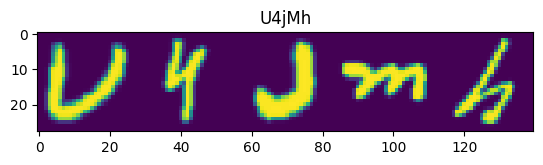

In [11]:
test_image,l = generate_word()
word = ""
for c in l:
  word = word + class_names[c]
plt.imshow(test_image)
plt.title(word)

[58  8 18 60 33 26]
w8IyXQ
word min/max 0.0 1.0


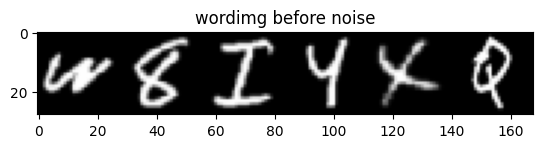

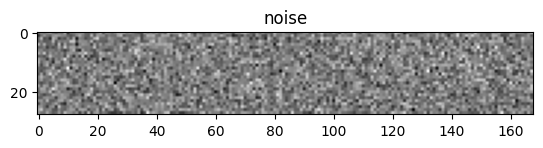

noise min/max -0.719510134706706 0.7270296376794922


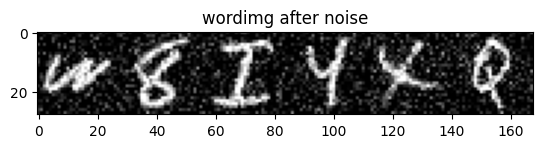

float64
noisy word min/max 0.0 1.0



In [12]:
max_length  = 9
min_length = 1
word_length = np.random.randint(min_length, max_length)
random_labels = np.random.randint(0, NUM_CLASS, size=(word_length))
random_chars = [random.choice(emnist_cache[l]) for l in random_labels]
print(random_labels)
word = ""
for c in random_labels:
  word = word + class_names[c]
print(word)
'''for i,img in enumerate(random_chars):
  print(class_names[random_labels[i]])
  plt.imshow(img)
  plt.title(class_names[random_labels[i]])
  plt.show()'''
word_img = np.hstack([np.asarray(img).squeeze() for img in random_chars])
word_img = word_img.astype("float32")

print("word min/max",word_img.min(), word_img.max())
plt.imshow(word_img, cmap='gray')
plt.title("wordimg before noise")
plt.show()

if(random.random() < 1):
  noise = np.random.normal(0,0.2,word_img.shape)
  plt.imshow(noise, cmap='gray')
  plt.title("noise")
  plt.show()
  word_img = np.clip(word_img+noise,0,1)
  print("noise min/max",noise.min(), noise.max())


plt.imshow(word_img, cmap='gray')
plt.title("wordimg after noise")

plt.show()
print(word_img.dtype)
print("noisy word min/max",word_img.min(), word_img.max())
print()


CTC loss needs:

* X image batch (fixed size)	CRNN expects uniform tensor sizes
* Y label sequence padded	CTC algorithm ignores padded values
* W input sequence lengths	Derived from CNN time dimension
* L target label lengths	So CTC knows actual target size

TRAINING DATASET

In [13]:
SAMPLE_NUM = 90000
#makin data set of the samples
images_samples =[] #generated image
padded_labels = [] #label sequece for respective word image
label_lengths = [] #label length(no padding)
widths= []#width of each word
label_max_len = 0 #to pad the labels to fix size for ctc
image_max_width = 0#to pad the images to same width()the time dimesion for ctc
for i in range(SAMPLE_NUM):
  img,lab = generate_word()
  h,w = img.shape
  image_max_width = max(image_max_width,w)
  label_max_len = max(label_max_len,len(lab))
  images_samples.append(img)
  padded_labels.append(lab)
  label_lengths.append(len(lab))
  widths.append(w)



(90000, 28, 224, 1)
(90000, 8)
(90000,)
(90000,)


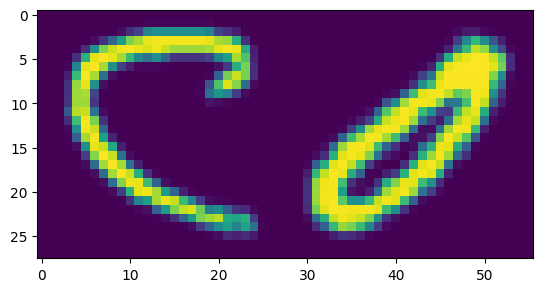

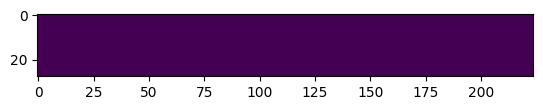

In [14]:
padded_images_set = np.zeros((SAMPLE_NUM, 28, image_max_width, 1))
padded_label_set = np.ones((SAMPLE_NUM, label_max_len))*-1
actual_width_set = np.zeros((SAMPLE_NUM))
actual_label_len_set = np.zeros((SAMPLE_NUM))
print(padded_images_set.shape)
print(padded_label_set.shape)
print(actual_width_set.shape)
print(actual_label_len_set.shape)
plt.imshow(images_samples[2])
plt.show()
plt.imshow(padded_images_set[2].squeeze())
plt.show()

In [15]:
for i, img in enumerate(images_samples):
  h,w = img.shape
  crop_w = min(w,image_max_width)
  padded_images_set[i,:,:crop_w, 0] = img[:,:crop_w]
  actual_width_set[i] = crop_w
  label = padded_labels[i]
  padded_label_set[i,:len(label)] = label
  actual_label_len_set[i] = len(label)


In [16]:
np.save("image_set.npy", padded_images_set)
np.save("label_set.npy", padded_label_set)
np.save("width_set.npy", actual_width_set)
np.save("label_len_set.npy", actual_label_len_set)

In [17]:
Y_shift = (padded_label_set+1).astype(np.int32)
X = padded_images_set
Wset = actual_width_set
Lset = actual_label_len_set

In [14]:
Y = np.load("label_set.npy", mmap_mode='r')
Y_shift = (Y+1).astype(np.int32)
X = np.load('image_set.npy', mmap_mode='r')
Wset = np.load('width_set.npy', mmap_mode='r')
Lset = np.load('label_len_set.npy', mmap_mode='r')

In [15]:
print("X", X.shape, X.dtype, "min/max:", X.min(), X.max())
print("widths min/max:", Wset.min(), Wset.max())
print("label lens min/max:", Lset.min(), Lset.max())

X (90000, 28, 224, 1) float64 min/max: 0.0 1.0
widths min/max: 56.0 224.0
label lens min/max: 2.0 8.0


In [16]:
n_train = int(0.8*X.shape[0])
n_val = int(len(X)-n_train)
print(n_train)
print(len(X[:n_val]))

72000
18000


In [17]:
X_train, X_val = X[:n_train], X[n_train:]
print(len(X_train), len(X_val))

72000 18000


In [18]:
X_train, X_val = X[:n_train], X[n_train:]
Yshift_train, Yshift_val = Y_shift[:n_train], Y_shift[n_train:]
W_train, W_val = Wset[:n_train], Wset[n_train:]
L_train, L_val = Lset[:n_train], Lset[n_train:]

In [19]:
train_ds = tf.data.Dataset.from_tensor_slices((tf.cast(X_train, tf.float32),Yshift_train,L_train,W_train))
train_ds = train_ds.shuffle(2048)
train_ds=train_ds.batch(32)

In [20]:
for batch in train_ds.take(1):
    imgs, labels, lens, widths = batch
    print("IMG SHAPE:", imgs.shape)
    print("LABELS SHAPE:", labels.shape)
    print("FIRST LABEL:", labels[0][:int(lens[0].numpy())])
    break

IMG SHAPE: (32, 28, 224, 1)
LABELS SHAPE: (32, 8)
FIRST LABEL: tf.Tensor([21 40  6 52 22 26], shape=(6,), dtype=int32)


In [21]:
val_ds = tf.data.Dataset.from_tensor_slices((tf.cast(X_val, tf.float32),Yshift_val,L_val,W_val))
val_ds = val_ds.shuffle(2048)
val_ds=val_ds.batch(32)

for batch in val_ds.take(1):
    imgs, labels, lens, widths = batch
    print("IMG SHAPE:", imgs.shape)
    print("LABELS SHAPE:", labels.shape)
    print("FIRST LABEL:", labels[0][:int(lens[0].numpy())])
    break

IMG SHAPE: (32, 28, 224, 1)
LABELS SHAPE: (32, 8)
FIRST LABEL: tf.Tensor([ 5 25 33 50 28 25 26], shape=(7,), dtype=int32)


In [22]:
train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 28, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [23]:
val_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 28, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

CNN+RNN architecture


In [77]:
  inp =  layers.Input((28,None,1), name = 'input_image')
  x = inp
    #conv stack(x)
  x=  layers.Conv2D(64, 3, activation='relu',padding='same')(x)
  x=  layers.MaxPooling2D((2,2), strides=(2,2))(x)#h/=2,w/=2,c=64
  x=  layers.Conv2D(128,3,activation='relu',padding='same')(x)
  x=  layers.MaxPooling2D((2,1), strides=(2,1))(x)#h/=2,w=w,c=128
  x=  layers.BatchNormalization()(x)
  x=  layers.Conv2D(256,3,activation='relu',padding='same')(x)
  x=  layers.MaxPooling2D((2,1), strides=(2,1))(x) #h/=2,w=w,c=256
  x=  layers.BatchNormalization()(x)
  x=  layers.Conv2D(512,3,activation='relu',padding='same')(x) #h/=2,w=w,c=512
    #h=1, w= 12(timesteps), features = 512
    #collapsing heit and features
  x=  layers.Permute((2,1,3))(x) #(B,W,H,C)
  print(x.shape)

  x=  layers.Reshape((-1, x.shape[2]*x.shape[3]))(x)
  print(x.shape)

  # rnn layers
  x = layers.Bidirectional(layers.LSTM(256, return_sequences='True'))(x)
  x = layers.Bidirectional(layers.LSTM(256, return_sequences='True'))(x)
  # logits for CTC
  x = layers.Dense(NUM_CLASSES+1, activation='softmax')(x)

print(x.shape)
model = Model(inp,x)
model.summary()


(None, None, 3, 512)
(None, None, 1536)
(None, None, 63)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 28, None, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_83 (Conv2D)              │ (None, 28, None, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_63 (MaxPooling2D) │ (None, 14, None, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_84 (Conv2D)              │ (None, 14, None, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_64 (MaxPooling2D) │ (None, 7, None, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 7, None, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_85 (Conv2D)              │ (None, 7, None, 256)   │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_65 (MaxPooling2D) │ (None, 3, None, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 3, None, 256)   │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_86 (Conv2D)              │ (None, 3, None, 512)   │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute_16 (Permute)            │ (None, None, 3, 512)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_12 (Reshape)            │ (None, None, 1536)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_18                │ (None, None, 512)      │     3,672,064 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_19                │ (None, None, 512)      │     1,574,912 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, None, 63)       │        32,319 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,830,655 (26.06 MB)

 Trainable params: 6,829,887 (26.05 MB)

 Non-trainable params: 768 (3.00 KB)

In [79]:
max_w = X.shape[2]
dummy = np.zeros((1, 28, max_w, 1), dtype=np.float32)
pred = model(dummy)
print("Model output time steps (for max width):", pred.shape[1])


Model output time steps (for max width): 112


In [61]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 28, None, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 14, None, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 14, None, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 7, None, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 7, None, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 7, None, 256)   │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 3, None, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 3, None, 256)   │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 3, None, 512)   │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute_2 (Permute)             │ (None, None, 3, 512)   │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,551,360 (5.92 MB)

 Trainable params: 1,550,592 (5.92 MB)

 Non-trainable params: 768 (3.00 KB)

KeyboardInterrupt: 

Label: ['T', 'q', 'V', 'N', 'i', 'W']


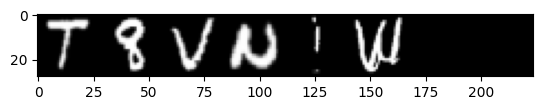

rcnn end

In [ ]:
train_ds = ds_train.map(preprocess).shuffle(10000).batch(128)
test_ds = ds_test.map(preprocess).batch(128)
print(train_ds)
print(test_ds)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


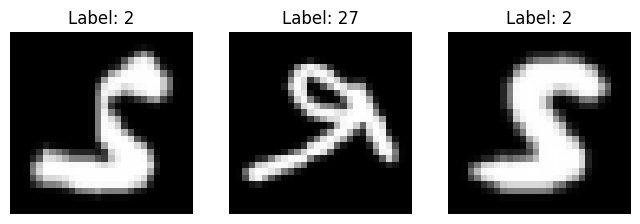

In [ ]:
for images, labels in train_ds.take(1):
    images = images.numpy()
    labels = labels.numpy()
    plt.figure(figsize=(8, 3))
for i in range(3):
    plt.subplot(1, 3, i + 1)  # 1 row, 3 columns
    plt.imshow(images[i].squeeze(), cmap="gray")  # squeeze for single channel
    plt.title(f"Label: {labels[i]}")
    plt.axis("off")

plt.show()

#preprocessiing

* the shape of the images and labels is expected

* idek why the batched dataset shape isnt matching


* Conv2D(32, (3,3))	Detects basic features like edges
* MaxPooling2D((2,2))	Reduces spatial size, downsampling
* Conv2D(64, (3,3))	Detects more complex features
* MaxPooling2D((2,2))	Further downsamples, reduces computation
* Flatten()	Converts 3D feature map into 1D vector
* Dense(64)	Fully connected layer for learning patterns
* Dense(NUM_CLASS)	Final output: 62 classes → softmax gives class probabilitie

In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(NUM_CLASS,activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()
for images, labels in train_ds.take(1):
    print(images.shape)
    print(labels.shape)
for images, labels in test_ds.take(1):
    print(images.shape)
    print(labels.shape)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 62)             │         4,030 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,310 (489.49 KB)

 Trainable params: 125,310 (489.49 KB)

 Non-trainable params: 0 (0.00 B)

(128, 28, 28, 1)
(128,)
(128, 28, 28, 1)
(128,)


In [ ]:
history = model.fit(train_ds, epochs=10, validation_data=test_ds)

Epoch 1/10
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 118s 21ms/step - accuracy: 0.7620 - loss: 0.7970 - val_accuracy: 0.8483 - val_loss: 0.4263
Epoch 2/10
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 110s 20ms/step - accuracy: 0.8516 - loss: 0.4175 - val_accuracy: 0.8546 - val_loss: 0.3974
Epoch 3/10
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 111s 20ms/step - accuracy: 0.8599 - loss: 0.3852 - val_accuracy: 0.8594 - val_loss: 0.3800
Epoch 4/10
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 141s 20ms/step - accuracy: 0.8651 - loss: 0.3675 - val_accuracy: 0.8632 - val_loss: 0.3736
Epoch 5/10
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 118s 21ms/step - accuracy: 0.8681 - loss: 0.3557 - val_accuracy: 0.8625 - val_loss: 0.3709
Epoch 6/10
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 119s 22ms/step - accuracy: 0.8703 - loss: 0.3472 - val_accuracy: 0.8641 - val_loss: 0.3697
Epoch 7/10
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 116s 21ms/step - accuracy: 0.8722 - loss: 0.3409 - val_accuracy: 0.8646 - val_loss: 0.3708
Epoch 8/10
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 116s 21ms/step - accuracy: 

In [ ]:
results = model.evaluate(test_ds)
print("Test results (loss, accuracy):", results)

909/909 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.8622 - loss: 0.3770
Test results (loss, accuracy): [0.377856582403183, 0.8624089956283569]


In [ ]:
class_names = ['0','1','2','3','4','5','6','7','8','9',
               'A','B','C','D','E','F','G','H','I','J',
               'K','L','M','N','O','P','Q','R','S','T',
               'U','V','W','X','Y','Z',
               'a','b','c','d','e','f','g','h','i','j',
               'k','l','m','n','o','p','q','r','s','t',
               'u','v','w','x','y','z']

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step  


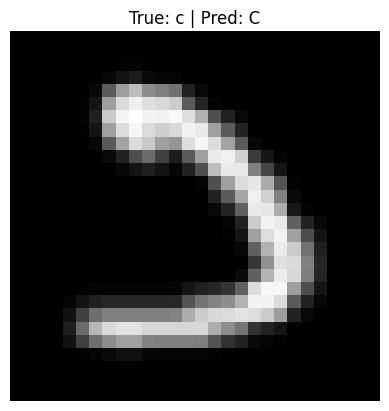

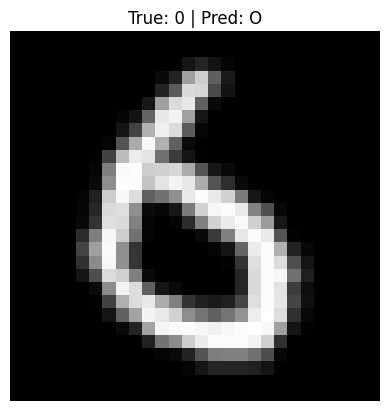

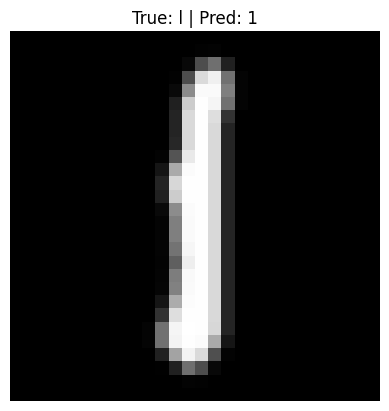

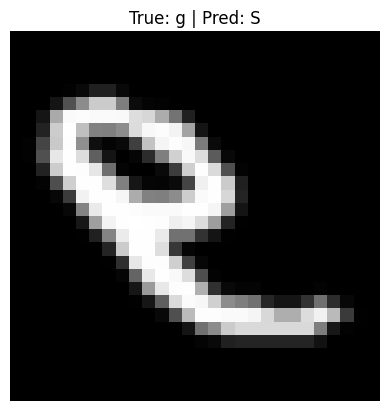

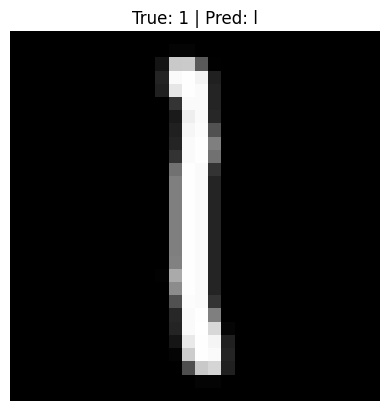

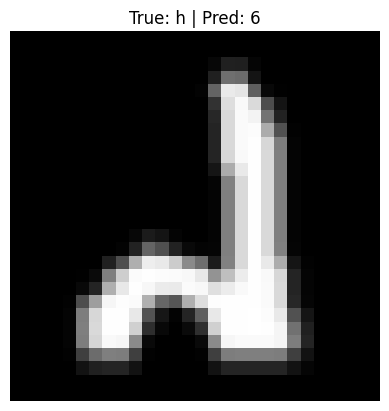

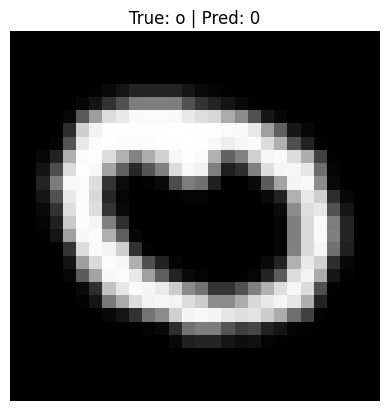

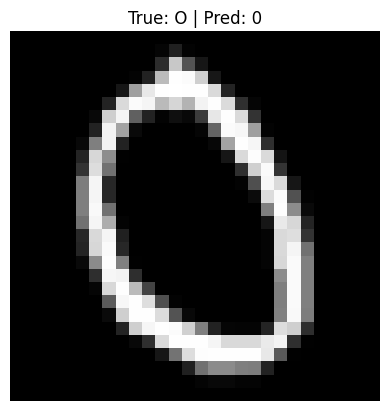

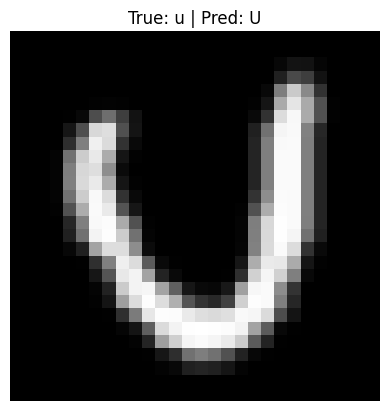

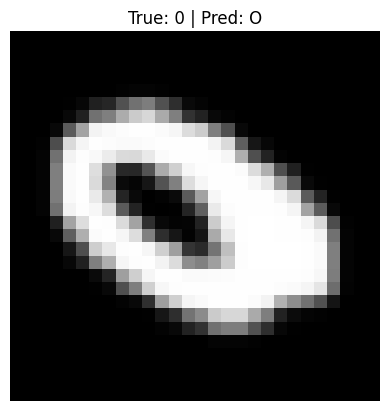

[  9  33  36  45  51  63  69  81  93  95  99 100 101 103 108 113]


In [ ]:
for images, label in test_ds.take(1):
  pred = model.predict(images)
  pred_labels = np.argmax(pred, axis=1)
  wrong_idx = np.where(pred_labels != labels.numpy())[0]
  for i in wrong_idx[:10]:  # Show first 10 mistakes
    plt.imshow(images[i].numpy().squeeze(), cmap='gray')
    plt.title(f"True: {class_names[labels[i]]} | Pred: {class_names[pred_labels[i]]}")
    plt.axis('off')
    plt.show()
print(wrong_idx)


